C:\Users\hp\AppData\Local\Temp\ipykernel_24236\3460986797.py:11: DtypeWarning:

Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.



Starting Comprehensive EDA Analysis...
DATA QUALITY ASSESSMENT
Dataset Shape: (1000098, 52)
Memory Usage: 2110.59 MB

Missing Values Summary:
                     Column  Missing Count  Missing Percentage
38  NumberOfVehiclesInFleet        1000098          100.000000
37              CrossBorder         999400           99.930207
29      CustomValueEstimate         779642           77.956560
35                  Rebuilt         641901           64.183810
36                Converted         641901           64.183810
34               WrittenOff         641901           64.183810
33               NewVehicle         153295           15.327998
8                      Bank         145961           14.594670
9               AccountType          40232            4.022806
11                   Gender           9536            0.953507

Data Types Summary:
object     36
float64    11
int64       4
bool        1
Name: count, dtype: int64

DESCRIPTIVE STATISTICS

Numeric Columns (15):
       Underwri

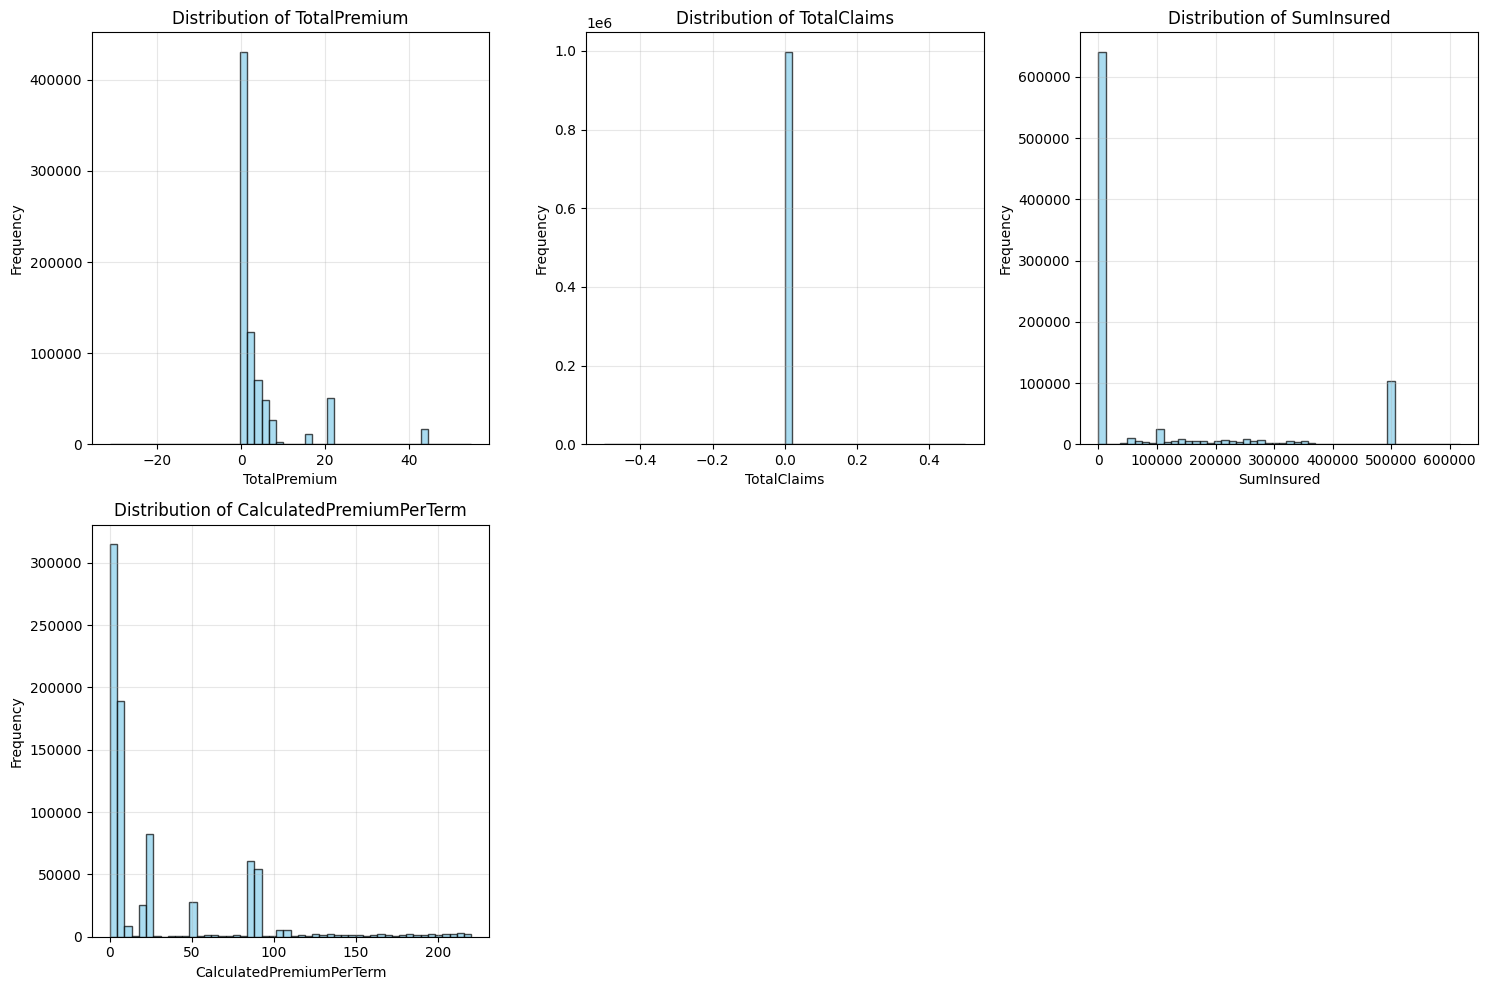

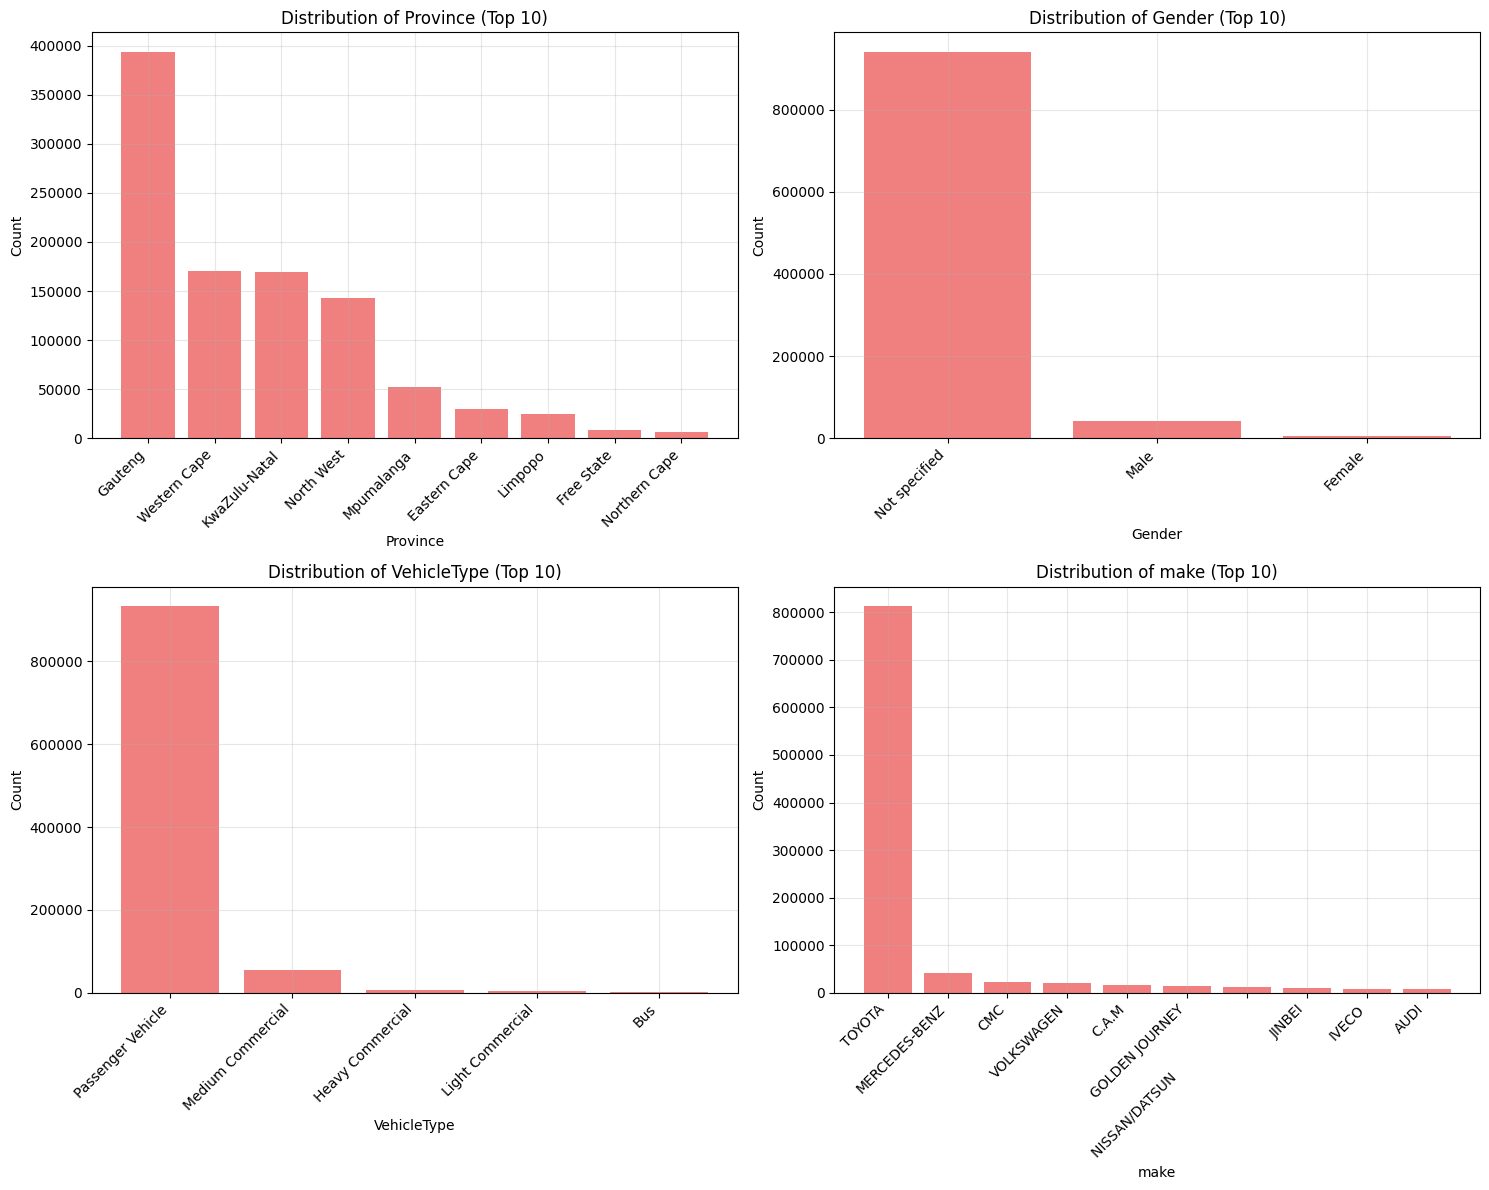


Analyzing Loss Ratio by Segments...


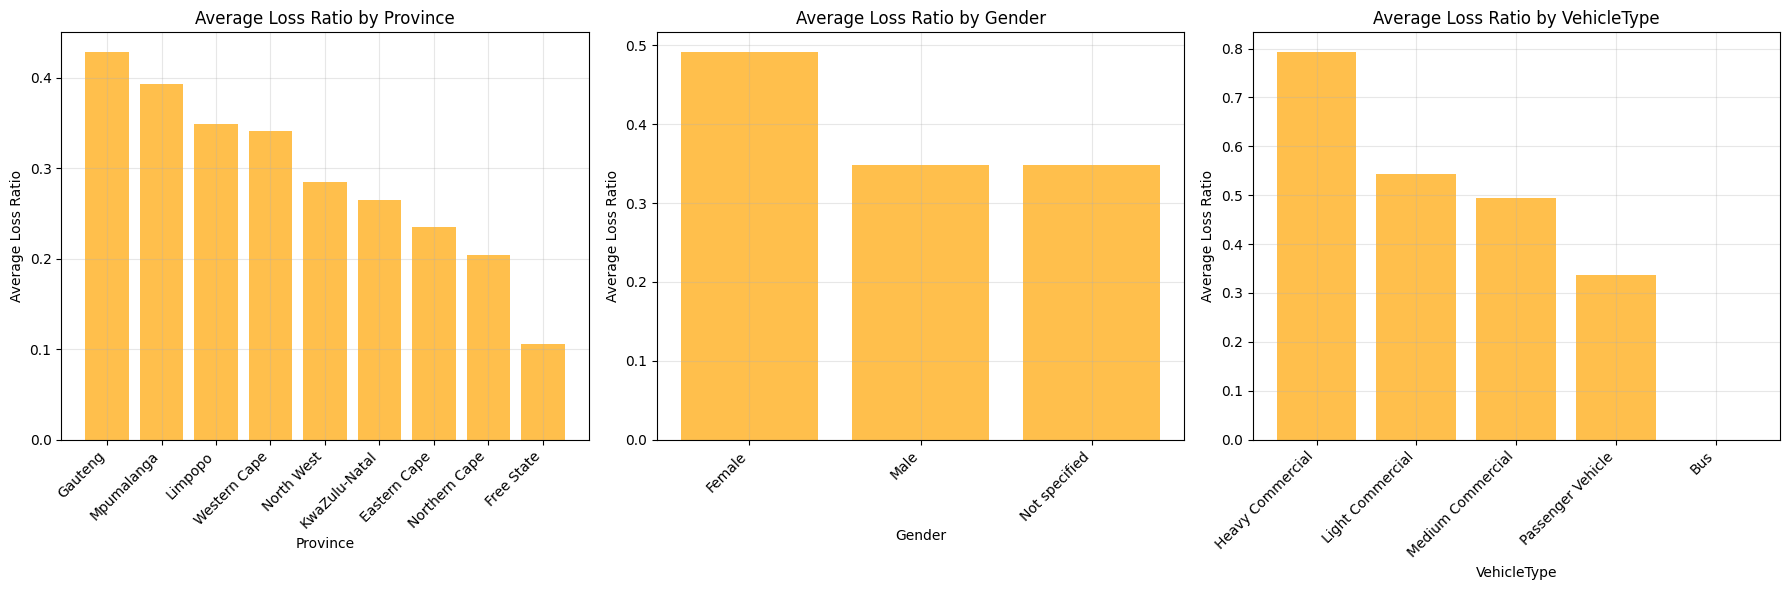


Creating Creative Visualizations...
Creating Visualization 1: Premium vs Claims Analysis...


Creating Visualization 2: Monthly Trends Analysis...


Creating Visualization 3: Risk Heatmap...


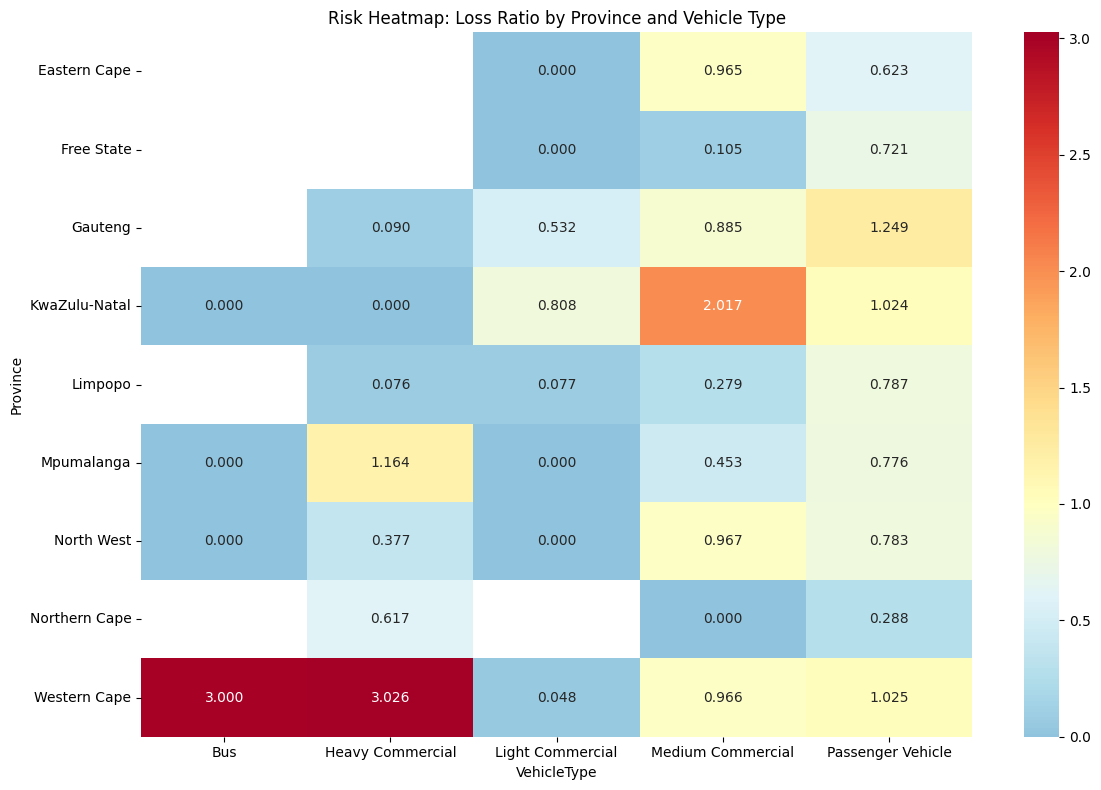


OUTLIER DETECTION


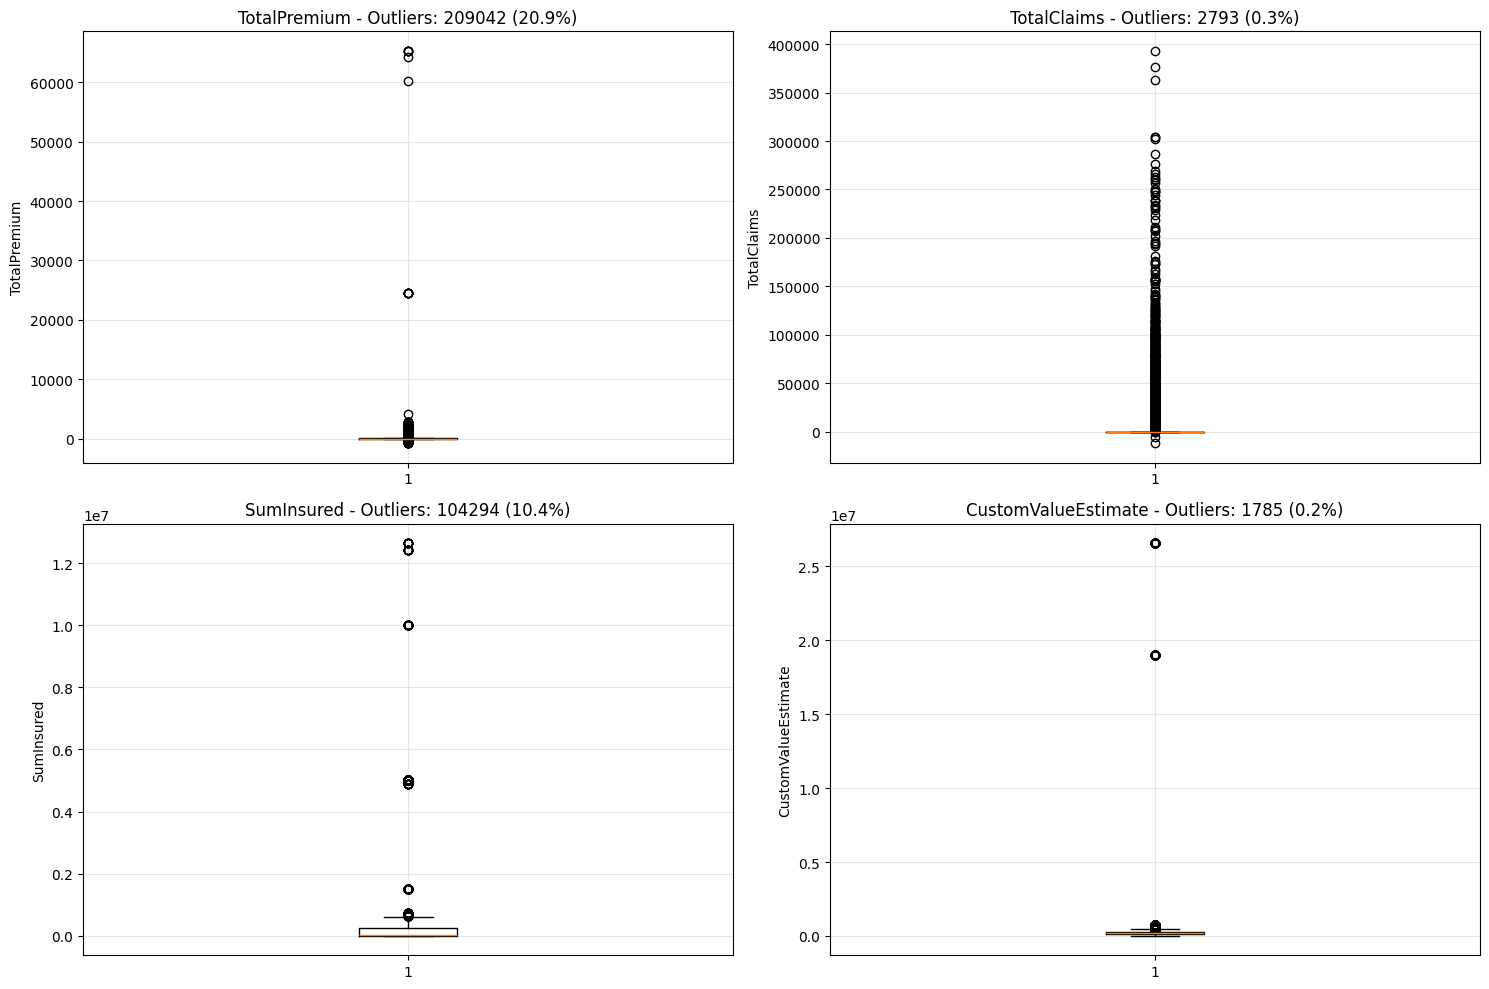


EDA Analysis Complete!
Key findings saved to reports/task1_eda_report.md


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load processed data
df = pd.read_csv('../data/processed/insurance_data.csv')

# ================================
# 1. DATA QUALITY ASSESSMENT
# ================================

def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    print("=" * 50)
    print("DATA QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Basic info
    print(f"Dataset Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing Percentage': missing_percent.values
    }).sort_values('Missing Percentage', ascending=False)
    
    print("\nMissing Values Summary:")
    print(missing_df[missing_df['Missing Percentage'] > 0].head(10))
    
    # Data types
    print("\nData Types Summary:")
    print(df.dtypes.value_counts())
    
    return missing_df

# ================================
# 2. DESCRIPTIVE STATISTICS
# ================================

def generate_descriptive_stats(df):
    """Generate comprehensive descriptive statistics"""
    print("\n" + "=" * 50)
    print("DESCRIPTIVE STATISTICS")
    print("=" * 50)
    
    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\nNumeric Columns ({len(numeric_cols)}):")
    print(df[numeric_cols].describe())
    
    # Key financial metrics
    if 'TotalPremium' in df.columns and 'TotalClaims' in df.columns:
        # Calculate Loss Ratio
        df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
        df['LossRatio'] = df['LossRatio'].replace([np.inf, -np.inf], np.nan)
        
        print(f"\nKey Financial Metrics:")
        print(f"Total Premium Sum: ${df['TotalPremium'].sum():,.2f}")
        print(f"Total Claims Sum: ${df['TotalClaims'].sum():,.2f}")
        print(f"Overall Loss Ratio: {df['TotalClaims'].sum() / df['TotalPremium'].sum():.3f}")
        print(f"Average Loss Ratio: {df['LossRatio'].mean():.3f}")
        print(f"Median Loss Ratio: {df['LossRatio'].median():.3f}")

# ================================
# 3. UNIVARIATE ANALYSIS
# ================================

def plot_numerical_distributions(df, columns):
    """Plot distributions for numerical columns"""
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.ravel() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Remove outliers for better visualization
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_data = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col]
            
            axes[i].hist(filtered_data.dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df, columns):
    """Plot distributions for categorical columns"""
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
    axes = axes.ravel() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Get top 10 categories to avoid overcrowding
            top_categories = df[col].value_counts().head(10)
            
            axes[i].bar(range(len(top_categories)), top_categories.values, color='lightcoral')
            axes[i].set_title(f'Distribution of {col} (Top 10)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(range(len(top_categories)))
            axes[i].set_xticklabels(top_categories.index, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# ================================
# 4. BIVARIATE ANALYSIS
# ================================

def analyze_loss_ratio_by_segments(df):
    """Analyze loss ratio across different segments"""
    if 'LossRatio' not in df.columns:
        df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
        df['LossRatio'] = df['LossRatio'].replace([np.inf, -np.inf], np.nan)
    
    segments = ['Province', 'Gender', 'VehicleType']
    
    fig, axes = plt.subplots(1, len(segments), figsize=(18, 6))
    
    for i, segment in enumerate(segments):
        if segment in df.columns:
            # Calculate loss ratio by segment
            segment_loss_ratio = df.groupby(segment)['LossRatio'].agg(['mean', 'count']).reset_index()
            segment_loss_ratio = segment_loss_ratio[segment_loss_ratio['count'] >= 100]  # Filter segments with sufficient data
            segment_loss_ratio = segment_loss_ratio.sort_values('mean', ascending=False).head(10)
            
            axes[i].bar(range(len(segment_loss_ratio)), segment_loss_ratio['mean'], color='orange', alpha=0.7)
            axes[i].set_title(f'Average Loss Ratio by {segment}')
            axes[i].set_xlabel(segment)
            axes[i].set_ylabel('Average Loss Ratio')
            axes[i].set_xticks(range(len(segment_loss_ratio)))
            axes[i].set_xticklabels(segment_loss_ratio[segment], rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# 5. CREATIVE VISUALIZATIONS
# ================================

def create_creative_visualizations(df):
    """Create three creative and insightful visualizations"""
    
    # Visualization 1: Premium vs Claims Scatter with Loss Ratio Color
    print("Creating Visualization 1: Premium vs Claims Analysis...")
    
    # Sample data for better performance
    sample_df = df.sample(n=min(10000, len(df)), random_state=42)
    
    fig = px.scatter(
        sample_df, 
        x='TotalPremium', 
        y='TotalClaims',
        color='LossRatio',
        size='SumInsured',
        hover_data=['Province', 'VehicleType'],
        title='Premium vs Claims Analysis (Sample)',
        color_continuous_scale='RdYlBu_r'
    )
    fig.show()
    
    # Visualization 2: Time Series Analysis
    print("Creating Visualization 2: Monthly Trends Analysis...")
    
    if 'TransactionMonth' in df.columns:
        df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
        monthly_trends = df.groupby(df['TransactionMonth'].dt.to_period('M')).agg({
            'TotalPremium': 'sum',
            'TotalClaims': 'sum',
            'PolicyID': 'count'
        }).reset_index()
        monthly_trends['LossRatio'] = monthly_trends['TotalClaims'] / monthly_trends['TotalPremium']
        monthly_trends['TransactionMonth'] = monthly_trends['TransactionMonth'].astype(str)
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Monthly Premium', 'Monthly Claims', 'Policy Count', 'Loss Ratio'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        fig.add_trace(go.Scatter(x=monthly_trends['TransactionMonth'], y=monthly_trends['TotalPremium'],
                                name='Premium', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=monthly_trends['TransactionMonth'], y=monthly_trends['TotalClaims'],
                                name='Claims', line=dict(color='red')), row=1, col=2)
        fig.add_trace(go.Scatter(x=monthly_trends['TransactionMonth'], y=monthly_trends['PolicyID'],
                                name='Policy Count', line=dict(color='green')), row=2, col=1)
        fig.add_trace(go.Scatter(x=monthly_trends['TransactionMonth'], y=monthly_trends['LossRatio'],
                                name='Loss Ratio', line=dict(color='orange')), row=2, col=2)
        
        fig.update_layout(height=600, title_text="Insurance Business Trends Over Time")
        fig.show()
    
    # Visualization 3: Risk Heatmap by Province and Vehicle Type
    print("Creating Visualization 3: Risk Heatmap...")
    
    if 'Province' in df.columns and 'VehicleType' in df.columns:
        # Create risk matrix
        risk_matrix = df.groupby(['Province', 'VehicleType']).agg({
            'TotalClaims': 'sum',
            'TotalPremium': 'sum',
            'PolicyID': 'count'
        }).reset_index()
        
        risk_matrix['LossRatio'] = risk_matrix['TotalClaims'] / risk_matrix['TotalPremium']
        risk_matrix = risk_matrix[risk_matrix['PolicyID'] >= 50]  # Filter for statistical significance
        
        # Pivot for heatmap
        heatmap_data = risk_matrix.pivot(index='Province', columns='VehicleType', values='LossRatio')
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu_r', center=1.0, fmt='.3f')
        plt.title('Risk Heatmap: Loss Ratio by Province and Vehicle Type')
        plt.tight_layout()
        plt.show()

# ================================
# 6. OUTLIER DETECTION
# ================================

def detect_outliers(df):
    """Detect outliers in key numerical columns"""
    print("\n" + "=" * 50)
    print("OUTLIER DETECTION")
    print("=" * 50)
    
    key_columns = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CustomValueEstimate']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    outlier_summary = {}
    
    for i, col in enumerate(key_columns):
        if col in df.columns:
            # Calculate IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_summary[col] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(df)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            # Box plot
            axes[i].boxplot(df[col].dropna())
            axes[i].set_title(f'{col} - Outliers: {len(outliers)} ({(len(outliers)/len(df)*100):.1f}%)')
            axes[i].set_ylabel(col)
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return outlier_summary

# ================================
# MAIN EXECUTION
# ================================

if __name__ == "__main__":
    print("Starting Comprehensive EDA Analysis...")
    
    # 1. Data Quality Assessment
    missing_summary = assess_data_quality(df)
    
    # 2. Descriptive Statistics
    generate_descriptive_stats(df)
    
    # 3. Univariate Analysis
    print("\nGenerating Distribution Plots...")
    numeric_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm']
    categorical_cols = ['Province', 'Gender', 'VehicleType', 'make']
    
    plot_numerical_distributions(df, [col for col in numeric_cols if col in df.columns])
    plot_categorical_distributions(df, [col for col in categorical_cols if col in df.columns])
    
    # 4. Bivariate Analysis
    print("\nAnalyzing Loss Ratio by Segments...")
    analyze_loss_ratio_by_segments(df)
    
    # 5. Creative Visualizations
    print("\nCreating Creative Visualizations...")
    create_creative_visualizations(df)
    
    # 6. Outlier Detection
    outlier_results = detect_outliers(df)
    
    print("\nEDA Analysis Complete!")
    print("Key findings saved to reports/task1_eda_report.md")

In [1]:
import sys
!{sys.executable} -m pip install --upgrade nbformat


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
